In [193]:
import os
import json
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

In [368]:
class MovieLensRecommenderSystem():
    ''' This class represents the movie recommender system.
        It has all functions needed to read the input data
        and construct the graphs, compute the specific properties
        of the graphs, train a model with SGD and filter the
        learned features with graph signal processing techniques.
    '''
    
    
    def read_data(self, path):
        ''' Reads an input data file with a given path.
        
        Parameters
        ----------
        path: string
            Represents tha path to the file.
        
        Returns
        -------
        data: pd.DataFrame
            The actual data as pd.DataFrame object.
        '''
        
        # Read the file, get the needed features and rename them in a more convenient way
        data = pd.read_csv(path, delimiter = '\t', header = None).rename(columns = {0: 'user', 1: 'movie', 2: 'rating'})
        return data
    
    
    def get_similarity_matrix(self, data):
        ''' Calculates the cosine similarity between every
            row in the 'data'.
        
        Parameters
        ----------
        data: np.ndarray
            The input data for which the cosine similarity
            should be calculated. Every row considered as
            a different entity, thus the similarity is
            calculated for the rows.
        
        Returns
        -------
        sim: np.ndarray
            The cosine similarity matrix of the input data.
            If the data has a shape (N, M) then the output
            has a shape (N, N).
        '''
        
        # Calculate the dot product between every pair of rows
        sim = data.dot(data.T)
        
        # Calculate the length of each rows in (L2 norm)
        lens = np.power(np.matrix.diagonal(sim), 1 / 2)
        
        # Divide the each similarity entry with the length of the first vector
        sim = (sim.T / lens).T
        
        # Switch components, do the same thing as before -- divide each
        # rows with the length of the second vector in the product.
        # Then switch back to the original matrix.
        sim = sim.T
        sim = (sim.T / lens).T
        sim = sim.T
        
        return sim
    
    
    def compute_laplacian(self, adjacency: np.ndarray, normalize: bool = True):
        ''' Calculates the graph laplacian matrix for a given adjacency matrix.
        
        Parameters
        ----------
        adjacency: np.ndarray
            The adjacency matrix of the graph.
        
        normalize: bool
            If True, the normalized graph laplacian matrix will be computed.
        
        Returns
        -------
        L: np.ndarray
            The combinatorial or normalized graph laplacian matrix of the graph.
        '''
        
        # Make sure the adjacency matrix is symmetric
        assert (adjacency - adjacency.T).min(axis = 0).min(axis = 0) == 0

        # Get the degree and diagonal entries of the adjacency matrix
        W = adjacency
        deg = W.sum(axis = 0)
        D = np.diag(deg)

        # Calculate the combinatorial laplacian matrix
        L = D - W

        # Calculate the normalized laplacian matrix
        Dn = np.sqrt(np.linalg.inv(D))
        Ln = Dn.dot(L).dot(Dn)

        return Ln if normalize else L
    
    
    def spectral_decomposition(self, laplacian: np.ndarray):
        ''' Calculates the spectral (eigendecomposition) of a given (graph laplacian) matrix.
        
        Parameters
        ----------
        laplacian: np.ndarray
            The graph laplacian matrix.
        
        Returns
        -------
        lamb: np.ndarray
            Eigenvalues of the graph laplacian matrix (in sorted ascending order).
        
        U: np.ndarray
            The corresponding eigenvectors.
        '''
        R = laplacian
        lamb, U = np.linalg.eigh(R)    
        return lamb, U
    
    
    def number_of_connected_components(self, lamb: np.array, threshold: float = 1e-10):
        ''' Calculates the number of connected components in the graph for given
            eigenvalues of the graph laplacian matrix.
        
        Parameters
        ----------
        lamb: np.ndarray
            Eigenvalues of the graph laplacian matrix (in sorted ascending order).
        
        threshold: float
            The threshold for which, if less, we consider the eigenvalue to be 0.
        
        Returns
        -------
        num_connected_components: int
            The number of connected components.
        '''
        return np.sum((lamb < threshold).astype(int))
    
    
    def fit_polynomial(self, lam: np.ndarray, order: int, spectral_response: np.ndarray):
        ''' Caclulates the polynomial coefficients of the fitted curve for
            a given filter / spectral response.
        
        Parameters
        ----------
        lamb: np.ndarray
            Eigenvalues of the graph laplacian matrix (in sorted ascending order).
        
        order: int
            Specifies the degree of the polynomial to be fitted.
        
        spectral_response: np.ndarray
            Represents the desired filter that we want to approximate.
        
        Returns
        -------
        coeff: np.ndarray
            The coefficients of the approximation.
        '''
        V = np.vander(lam, order + 1, increasing = True)
        return np.linalg.lstsq(V, spectral_response, rcond = None)[0]
    
    
    def polynomial_graph_filter_response(self, coeff: np.array, lam: np.ndarray):
        ''' Calculates the actual fitted curve -- the approximation of the filter.
        
        Parameters
        ----------
        coeff: np.ndarray
            The coefficients of the approximation.
        
        lamb: np.ndarray
            Eigenvalues of the graph laplacian matrix (in sorted ascending order).
        
        Returns
        -------
        response: np.ndarray
            The actual values of the approximated filter.
        '''
        V = np.vander(lam, coeff.shape[0], increasing = True)
        return V.dot(coeff)

    
    def polynomial_graph_filter(self, coeff: np.array, laplacian: np.ndarray):
        ''' Calculates the laplacian polynomial with given coefficients.
        
        Parameters
        ----------
        coeff: np.ndarray
            The coefficients of the approximation.
        
        laplacian: np.ndarray
            The graph laplacian matrix.
        
        Returns
        -------
        polynom_graph_filter: np.ndarray
            The laplacian polynomial matrix with given coefficients.
        '''
        return sum(coeff[i] * np.linalg.matrix_power(laplacian, i) for i in range(len(coeff)))
    
    
    def __init__(self, train_data_path, seed = 17):
        ''' Initialization of the class. Contains many preprocessing steps.
        
        Parameters
        ----------
        train_data_path: string
            Represents the name of the training data file.
        
        seed: int
            Random seed used for reproducibility.
        '''
        
        # Initialize the parameters of the model
        self.DATA_DIR = 'ml-100k/'
        self.train_data_path = train_data_path
        self.seed = seed
        
        # Read the main input data
        self.train_df = self.read_data(os.path.join(self.DATA_DIR, self.train_data_path))
        # Read the additional movie data
        self.movie_df = pd.read_csv(os.path.join(self.DATA_DIR, 'u.item'), delimiter = '|',
                                    header = None, encoding = 'latin1') \
                          .drop(columns = [2, 3, 4]).rename(columns = {0: 'movie', 1: 'title'})
        
        # Find list of unique user IDs
        self.inv_map_users = list(set(self.train_df['user']))
        self.num_users = len(self.inv_map_users)

        # Find list of unique movie IDs
        self.inv_map_movies = list(set(self.train_df['movie']))
        self.num_movies = len(self.inv_map_movies)
        
        # Find mapping of the original user ID to [0, N - 1]
        # Useful for case when the user IDs are not indexed in [0, N - 1]
        self.map_users = {x: i for i, x in enumerate(self.inv_map_users)}
        self.map_movies = {x: i for i, x in enumerate(self.inv_map_movies)}
        
        # Apply the mapping of the IDs found above
        self.train_df['user'] = self.train_df['user'].apply(lambda x: self.map_users[x])
        self.train_df['movie'] = self.train_df['movie'].apply(lambda x: self.map_movies[x])
        self.movie_df['movie'] = self.movie_df['movie'].apply(lambda x: self.map_movies[x])
        
        # Compute mean and standard deviation for the ratings of the users and movies
        self.user_mean = self.train_df.groupby('user')['rating'].mean()
        self.user_std = self.train_df.groupby('user')['rating'].std()
        self.movie_mean = self.train_df.groupby('movie')['rating'].mean()
        self.movie_std = self.train_df.groupby('movie')['rating'].std()
        
        # Create users graph
        self.user_repr = np.zeros((self.num_users, self.num_movies))
        # Get the 'net' rating of each user -- subtract the mean of that user
        for u, i, r in zip(self.train_df['user'], self.train_df['movie'], self.train_df['rating']):
            self.user_repr[u, i] = (r - self.user_mean[u]) / self.user_std[u] # or do not really have to add / std, result is the same
        # Calculate cosine simlarity between these representations of the users
        self.user_similarity = self.get_similarity_matrix(self.user_repr)
        # Fix the similarity matrix so that each user is not connected with himself
        self.user_similarity -= np.identity(self.num_users)
        
        # Define some constat c_users such that only the similarities smaller than
        # c_users * mean will be converted into edges in the graph.
        c_users = 5.25
        user_mean_similarity = self.user_similarity.mean()
        self.user_adj = (self.user_similarity > c_users * user_mean_similarity).astype(int)
        
        # Calculate the normalized graph laplacian matrix
        self.user_laplacian_norm = self.compute_laplacian(self.user_adj)
        # Find its eigenvalues and eigenvectors
        self.user_lamb_norm, self.user_U_norm = self.spectral_decomposition(self.user_laplacian_norm)
#         print('Number of connected components on users graph: %d' % self.number_of_connected_components(self.user_lamb_norm))
        
#         plt.spy(self.user_adj)
#         plt.show()
        
        # Create a desired filter for the users
        self.user_ideal_filter = np.ones(self.num_users)
        self.user_ideal_filter[self.user_lamb_norm >= 0.7] = 0
        
        # Initialize the degree of polynomial approximation
        self.user_order = 15
        # Find the approximated coefficients
        self.user_coeff = self.fit_polynomial(self.user_lamb_norm, self.user_order, self.user_ideal_filter)
        # Find the approximated values of the filter
        self.user_graph_filter = self.polynomial_graph_filter(self.user_coeff, self.user_laplacian_norm)

#         plt.plot(self.user_lamb_norm, user_ideal_filter)
#         plt.plot(self.user_lamb_norm, self.polynomial_graph_filter_response(user_coeff, self.user_lamb_norm))
#         plt.legend(['Ideal', 'Polynomial'])
#         plt.xlabel('$\lambda$')
#         plt.ylabel('Spectral response')
#         plt.show()
        
        
        # Create movies graph
        self.movie_adj = np.zeros((self.num_movies, self.num_movies))
        # Sort the movies with respect to their mean rating
        sort_idx = self.movie_mean.to_numpy().argsort()
        # Connect the neighboring movies according to the mean rating
        # Makes a trivial tree with diameter M where M is the number of movies
        # I.e., m_1 - m_2 - ... - m_M-1 - m_M.
        for i, j in zip(sort_idx[1:], sort_idx[:-1]):
            self.movie_adj[i, j] = 1
            self.movie_adj[j, i] = 1
        
        # Define some constat c_movies such that the pairs of movies
        # whose mean rating differs with less than c_movies will be
        # converted into edges. It was chosen such that the graph
        # is connected, and is sparse enoguh.
        c_movies = 0.11
        for i in range(self.num_movies):
            for j in range(i + 1, self.num_movies):
                if self.movie_adj[i, j] == 0:
                    edge = 1 if abs(self.movie_mean[i] - self.movie_mean[j]) < c_movies else 0
                    self.movie_adj[i, j] = edge
                    self.movie_adj[j, i] = edge
        
        # Calculate the normalized graph laplacian matrix
        self.movie_laplacian_norm = self.compute_laplacian(self.movie_adj)
        # Find its eigenvalues and eigenvectors
        self.movie_lamb_norm, self.movie_U_norm = self.spectral_decomposition(self.movie_laplacian_norm)
#         print('Number of connected components on movies graph: %d' % self.number_of_connected_components(self.movie_lamb_norm))

#         plt.spy(self.movie_adj)
#         plt.show()
        
        # Create a desired filter for the movies
        self.movie_ideal_filter = np.ones(self.num_movies)
        self.movie_ideal_filter[self.movie_lamb_norm >= 0.35] = 0

        # Initialize the degree of polynomial approximation
        self.movie_order = 15
        # Find the approximated coefficients
        self.movie_coeff = self.fit_polynomial(self.movie_lamb_norm, self.movie_order, self.movie_ideal_filter)
        # Find the approximated values of the filter
        self.movie_graph_filter = self.polynomial_graph_filter(self.movie_coeff, self.movie_laplacian_norm)

#         plt.plot(self.movie_lamb_norm, self.movie_ideal_filter)
#         plt.plot(self.movie_lamb_norm, self.polynomial_graph_filter_response(self.movie_coeff, self.movie_lamb_norm))
#         plt.legend(['Ideal', 'Polynomial'])
#         plt.xlabel('$\lambda$')
#         plt.ylabel('Spectral response')
#         plt.show()
        
    
    def predict(self, P, Q, u, i):
        ''' Given the factorized matrices P, Q, ID of the user and movie,
            calculate the prediction.
        
        Parameters
        ----------
        P: np.ndarray
            The factorized -- embedding matrix of the users.
        
        Q: np.ndarray
            The factorized -- embedding matrix of the movies.
        
        u: int
            The ID of the user.
        
        i: int
            The ID of the movie.
        
        Returns
        -------
        r_pred: float
            The prediction for the user 'u' and movie 'i'.
        '''
        # Predict the rating of user u and movie i
        return P[u].dot(Q[i])
    
    
    def cross_validate(self, n_splits = 5, K = 50, learning_rate = .01, regularization_rate = .017, bias = True, seed = 17):
        ''' Evaluate the RMSE of the hyperparameters with cross-validation.
        
        Parameters
        ----------
        n_splits: int
            The number of folds in the cross-validation.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        seed: int
            Used for reproducibility.
        '''
        # Initialize KFold object
        kf = KFold(n_splits = 5, random_state = seed, shuffle = True)
        
        # Evaluate RMSE for every fold
        total_error = 0
        for it, (train_idx, val_idx) in enumerate(kf.split(self.train_df)):
            # Get the train and validation data
            train_data = self.train_df.loc[train_idx]
            val_data = self.train_df.loc[val_idx]
            
            # Get the RMSE for the it-th fold
            print('Fold: %d/%d' % (it + 1, n_splits))
            cur_error, P, Q = self.evaluate_matrix_factorization(train_data, val_data, K = K, learning_rate = learning_rate,
                                                           bias = bias, learn_max_it = 50, filter_max_it = 10,
                                                           regularization_rate = regularization_rate, seed = seed)
            print()
            
            # Get the total error (squared errors)
            total_error += np.power(cur_error, 2) * len(val_data)
        
        # Calculate the total RMSE for all n-folds (weighted, useful if the validation datasets have different sizes)
        final_error = np.power(total_error / len(self.train_df), 1 / 2)
        print('Error: %.5f' % final_error)
    
    
    def learning_step(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias):
        ''' Perform one SGD step on the data.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The updated factorized matrix for users.
        
        Q: np.ndarray
            The updated factorized matrix for movies.
        '''
        # For every entry in the training data
        for u, i, r in zip(train_data['user'], train_data['movie'], train_data['rating']):
            # Get the prediction, and error
            r_pred = self.predict(P, Q, u, i)
            e_ui = r - r_pred

            # Find the updates for the approriate rows in P and Q
            nP_u = P[u] + learning_rate * (e_ui * Q[i] - regularization_rate * P[u])
            nQ_i = Q[i] + learning_rate * (e_ui * P[u] - regularization_rate * Q[i])

            # Set the approriate element to be 1 for the bias
            if bias:
                nP_u[K] = 1
                nQ_i[K + 1] = 1

            # Update the matrices
            P[u] = nP_u
            Q[i] = nQ_i

        # Calculate RMSE on the validation dataset
        error = 0
        for u, i, r in zip(val_data['user'], val_data['movie'], val_data['rating']):
            # Get the prediction, and error
            r_pred = self.predict(P, Q, u, i)
            e_ui = r - r_pred

            # Error squared
            error += np.power(e_ui, 2)
        # Final RMSE
        error = np.power(error / len(val_data), 1 / 2)
        
        return error, P, Q
    
    
    def learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, max_it):
        ''' Perform at most 'max_it' SGD iterations, or until the RMSE on the validation data set increases.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        max_it: int
            The number of maximum SGD iterations.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        error = 1e9
        for it in range(max_it):
            # Copy the current factorized matrices
            nP, nQ = P.copy(), Q.copy()
            # Perform one SGD step
            cur_error, nP, nQ = x.learning_step(train_data, val_data, nP, nQ, K, learning_rate, regularization_rate, bias)
            # print('Learn  it: %3d\t%.5f' % (it, cur_error))
            
            # If RMSE on validation dataset increases, stop the learning
            if cur_error >= error:
                break
            
            # Else update the error and matrices
            error = cur_error
            P, Q = nP.copy(), nQ.copy()
        
        # print('-------------------------')
        # print('Final learn it: %3d\t%.5f\n' % (it, error))
        
        return error, P, Q
    
    
    def gsp_learn(self, graph_type, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, gsp, learn_max_it, filter_max_it):
        ''' A wrapper function for learning the factorized matrices if no graph signal processing (GSP) is specified.
            If GSP is specified, then graph_type should contain strings representing that the user or movies
            graphs should be used to denoise the features in P and Q respectively.
            The learning is as follows. Get inital embeddings. Try to apply the specified filter(s) for 'filter_max_it' times, or
            until RMSE on the validation dataset decreases. After each filter application, perform SGD steps on the denoised matrices P and Q.
        
        Parameters
        ----------
        graph_type: list of strings
            Represents the type(s) of graphs that will be used for filtering the features.
            If 'USERS' is in the list, then the user matrix P will be denoised with the users graph.
            If 'MOVIES' is in the list, then the movies matrix Q will be denoised with the movies graph. 
        
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        gsp: bool
            If True, graph signal processing will be applied to the features,
            according to the list 'graph_type'.
        
        max_it: int
            The number of maximum SGD iterations.
        
        filter_max_it: int
            The number of maximum times the filters should be applied to the
            features of the matrices P and Q.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        # Get the initial factorized matrices without before any filters are applied.
        error, P, Q = self.learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it)
        
        if gsp:
            for it in range(filter_max_it):
                nP, nQ = P.copy(), Q.copy()
                
                if 'USER' in graph_type:
                    nP[:, :K] = self.user_graph_filter.dot(nP[:, :K])
                
                if 'MOVIE' in graph_type:
                    nQ[:, :K] = self.movie_graph_filter.dot(nQ[:, :K])
                
                cur_error, nP, nQ = self.learn(train_data, val_data, nP, nQ, K, learning_rate, regularization_rate, bias, learn_max_it)

                # print('gsp_learn it: %3d\t%.5f\n\n' % (it, cur_error))
                if cur_error >= error:
                    break

                error = cur_error
                P, Q = nP.copy(), nQ.copy()
            
            # print('-------------------')
            # print('Final gsp_learn: %3d\t%.5f\n' % (it, error))
        
        return error, P, Q
    
    
    def movieuser_learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it):
        ''' A wrapper function for learning the factorized matrices if graph signal processing (GSP) is specified,
            such that both matrices P and Q are updated at the same time.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        max_it: int
            The number of maximum SGD iterations.
        
        filter_max_it: int
            The number of maximum times the filters should be applied to the
            features of the matrices P and Q.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        return self.gsp_learn(['USER', 'MOVIE'], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, True, learn_max_it, filter_max_it)
    
    
    def movie_user_learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it):
        ''' Evaluates the RMSE in the following way. First, try to apply the users filter 'filter_max_it' times,
            or until the RMSE on the validation set increases. Then, apply the movies fillter once and keep applying
            the users filter, as described previously.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        max_it: int
            The number of maximum SGD iterations.
        
        filter_max_it: int
            The number of maximum times the filters should be applied to the
            features of the matrices P and Q.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        # Get the best inital embeddings with users filter
        error, P, Q = self.gsp_learn(['USER'], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, True, learn_max_it, filter_max_it)
        
        for it in range(filter_max_it):
            # Copy the best matrices so far
            nP, nQ = P.copy(), Q.copy()
            
            # Apply the movies filter
            nQ[:, :K] = self.movie_graph_filter.dot(nQ[:, :K])
            # To new SGD steps and users filter application for max_it times or until RMSE on validation decreases
            cur_error, nP, nQ = self.gsp_learn(['USER'], train_data, val_data, nP, nQ, K, learning_rate / 10, regularization_rate, bias, True, learn_max_it, filter_max_it)
            # print('movie_user it: %3d\t%.5f\n\n' % (it, cur_error))
            
            # If validation RMSE increases, stop the learning
            if cur_error >= error:
                break
            
            # Update the error and matrices P and Q
            error = cur_error
            P, Q = nP.copy(), nQ.copy()
            
        # print('-------------------')
        print('Final movie_user: %3d\t%.5f\n' % (it, error))
        return error, P, Q
    
    
    def user_movie_learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it):
        ''' Evaluates the RMSE in the following way. First, try to apply the movies filter 'filter_max_it' times,
            or until the RMSE on the validation set increases. Then, apply the users fillter once and keep applying
            the movies filter, as described previously.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        max_it: int
            The number of maximum SGD iterations.
        
        filter_max_it: int
            The number of maximum times the filters should be applied to the
            features of the matrices P and Q.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        # Get the best inital embeddings with movies filter
        error, P, Q = self.gsp_learn(['MOVIE'], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, True, learn_max_it, filter_max_it)
        
        for it in range(filter_max_it):
            # Copy the best matrices so far
            nP, nQ = P.copy(), Q.copy()
            
            # Apply the movies filter
            nP[:, :K] = self.user_graph_filter.dot(nP[:, :K])
            # To new SGD steps and users filter application for max_it times or until RMSE on validation decreases
            cur_error, nP, nQ = self.gsp_learn(['MOVIE'], train_data, val_data, nP, nQ, K, learning_rate / 10, regularization_rate, bias, True, learn_max_it, filter_max_it)
            # print('user_movie it: %3d\t%.5f\n\n' % (it, cur_error))
            
            # If validation RMSE increases, stop the learning
            if cur_error >= error:
                break
            
            # Update the error and matrices P and Q
            error = cur_error
            P, Q = nP.copy(), nQ.copy()
            
        # print('-------------------')
        print('Final user_movie: %3d\t%.5f\n' % (it, error))
        return error, P, Q

    
    def evaluate_matrix_factorization(self, train_data, val_data, P = None, Q = None, K = 50, learning_rate = .01, regularization_rate = .017, bias = True, learn_max_it = 50, filter_max_it = 10, seed = 17):
        ''' Evaluates the RMSE of the hyperparameters with the desired technique of filter applications.
        
        Parameters
        ----------
        train_data: pd.DataFrame
            Represents the training data set.
        
        val_data: pd.DataFrame
            Represents the validation data set.
        
        P: np.ndarray
            The factorized (embedding) matrix of the users.
        
        Q: np.ndarray
            The factorized (embedding) matrix of the movies.
        
        K: int
            The number of latent dimensions for the factorized matrices.
        
        learning_rate: float
            Specifies the step size / learning rate of the SGD update.
        
        regularization_rate: float
            Specifies the regularization rate of the SGD update.
        
        bias: bool
            If True, train a model that takes into consideration
            the bias of the users and movies.
        
        learn_max_it: int
            The number of maximum SGD iterations.
        
        filter_max_it: int
            The number of maximum times the filters should be applied to the
            features of the matrices P and Q.
        
        Returns
        -------
        error: float
            RMSE error on the validation data set after the SGD updates.
        
        P: np.ndarray
            The factorized matrix of users that gives the best RMSE on the validation data set.
        
        Q: np.ndarray
            The factorized matrix of movies that gives the best RMSE on the validation data set.
        '''
        # Set the random seed
        np.random.seed(seed)
        
        # Latent space dimension (+ 2 if we use the 'bias' trick with users' and movies' mean ratings)
        dim = K + (2 if bias else 0)
        
        # If P is not given, randomly intialize it.
        if P is None:
            P = np.random.choice([-0.01, 0.01], size = self.num_users * dim).reshape((self.num_users, dim))
            
            # Initialize one column to be 1 so that we can learn the bias
            if bias:
                P[:, K] = 1
        
        # If Q is not given, randomly initialize it.
        if Q is None:
            Q = np.random.choice([-0.01, 0.01], size = self.num_movies * dim).reshape((self.num_movies, dim))
        
            # Initialize one column to be 1 so that we can learn the bias
            if bias:
                Q[:, K + 1] = 1
        
        # Standard MF model (with or no bias)
        # return self.gsp_learn([], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, False, learn_max_it, filter_max_it)
        
        # MF + User filtering
        # return self.gsp_learn(['USER'], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, True, learn_max_it, filter_max_it)
    
        # MF + Movie filtering
        return self.gsp_learn(['MOVIE'], train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, True, learn_max_it, filter_max_it)
    
        # MF + User & Movie filtering
        # return self.movieuser_learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it)
        
        # (MF + User) Movie filtering
        # return self.movie_user_learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it)
        
        # (MF + Movie) User filtering
        # return self.user_movie_learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it, filter_max_it)

In [369]:
x = MovieLensRecommenderSystem('u.data')
train = x.train_df[['user', 'movie', 'rating']].sample(frac = 1, random_state = 17)[:80000]
test = x.train_df[['user', 'movie', 'rating']].sample(frac = 1, random_state = 17)[80000:]
#error, P, Q = x.evaluate_matrix_factorization(train, test)

In [83]:
error, nP, nQ = x.evaluate_matrix_factorization(train, test)

In [ ]:
error, P, Q = x.evaluate_matrix_factorization(train, test, learning_rate = .017, regularization_rate = .051)

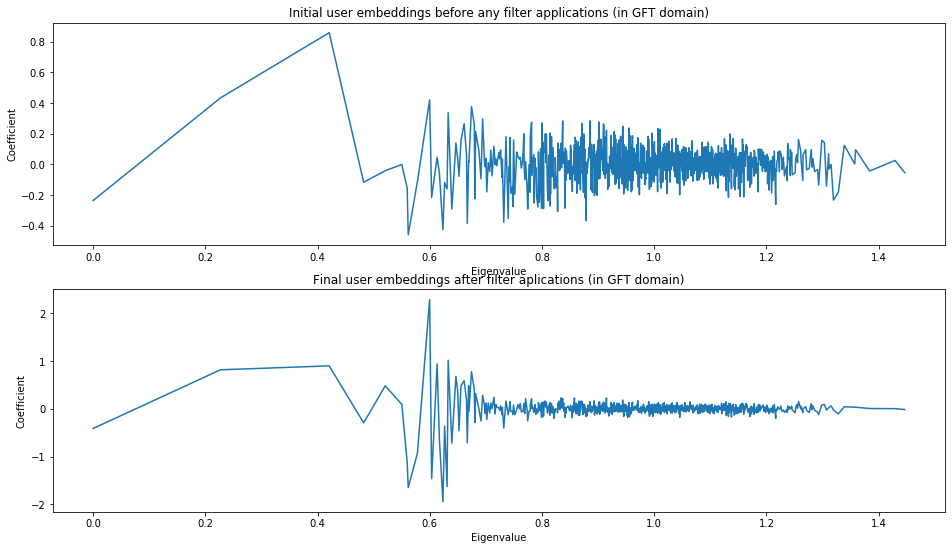

In [390]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 9))
# fig.suptitle('User embeddings without any denoising vs final embeddings after filter applications (in GFT domain)')

ax1.set_title('Initial user embeddings before any filter applications (in GFT domain)')
ax1.set_xlabel('Eigenvalue')
ax1.set_ylabel('Coefficient')
ax1.plot(x.user_lamb_norm, x.user_U_norm.T.dot(nP[:, 1]))

ax2.set_title('Final user embeddings after filter aplications (in GFT domain)')
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Coefficient')
ax2.plot(x.user_lamb_norm, x.user_U_norm.T.dot(P[:, 1]))

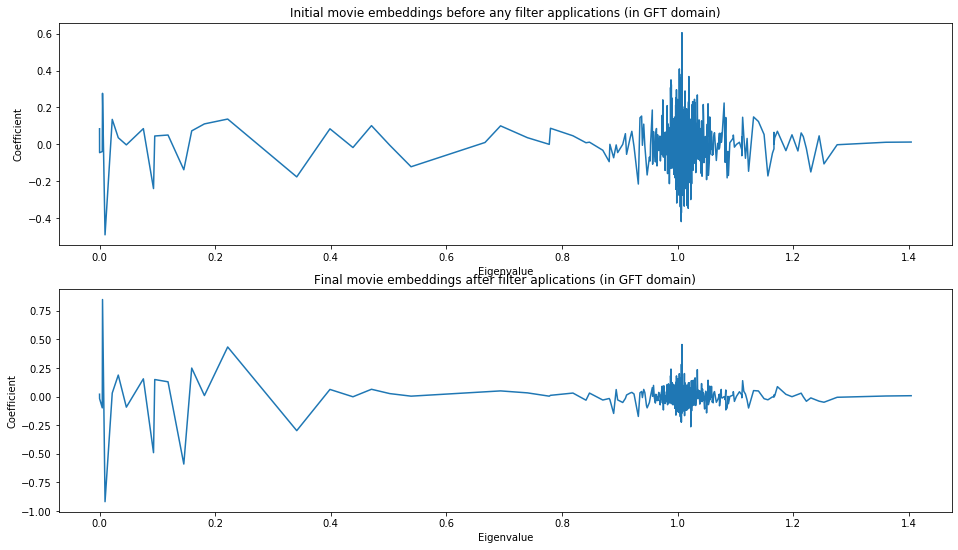

In [395]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 9))
# fig.suptitle('Movie embeddings without any denoising vs final embeddings after filter applications (in GFT domain)')

ax1.set_title('Initial movie embeddings before any filter applications (in GFT domain)')
ax1.set_xlabel('Eigenvalue')
ax1.set_ylabel('Coefficient')
ax1.plot(x.movie_lamb_norm, x.movie_U_norm.T.dot(nQ[:, 0]))

ax2.set_title('Final movie embeddings after filter aplications (in GFT domain)')
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Coefficient')
ax2.plot(x.movie_lamb_norm, x.movie_U_norm.T.dot(Q[:, 17]))

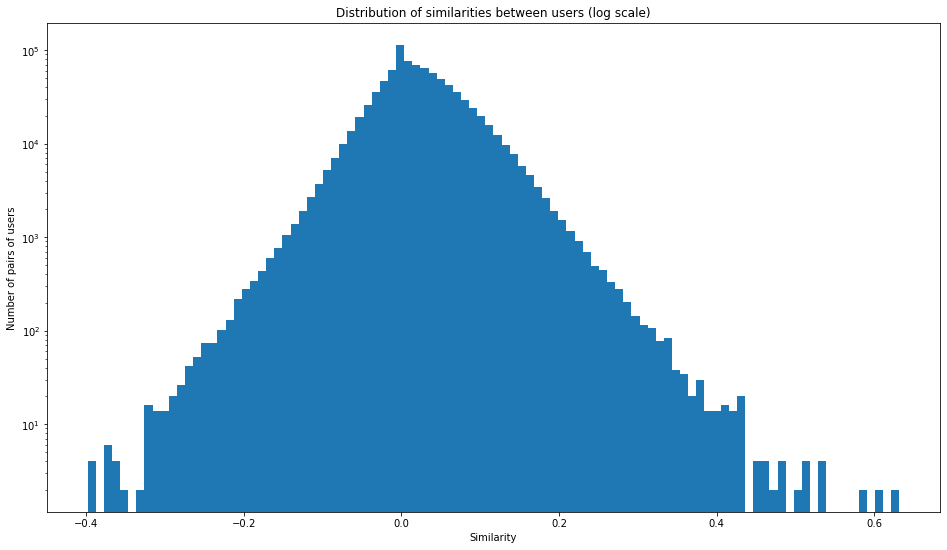

In [196]:
plt.figure(figsize=(16, 9))
plt.title('Distribution of similarities between users (log scale)')
plt.yscale('log')
plt.xlabel('Similarity')
plt.ylabel('Number of pairs of users')
plt.hist(x.user_similarity.ravel(), bins = 100);

Number of connected components on users graph: 1
Number of connected components on users graph: 1


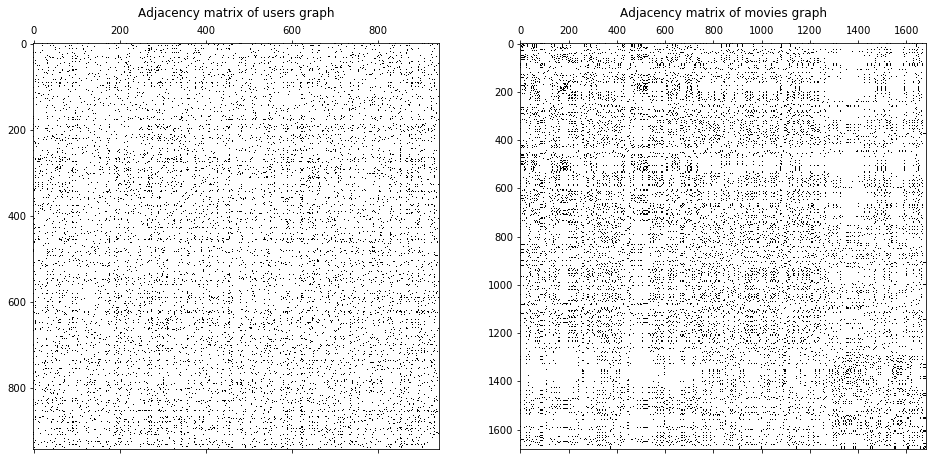

In [321]:
print('Number of connected components on users graph: %d' % x.number_of_connected_components(x.user_lamb_norm))
print('Number of connected components on users graph: %d' % x.number_of_connected_components(x.movie_lamb_norm))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 9))
# fig.suptitle('Adjacency matrices of users and movies graph')

ax1.set_title('Adjacency matrix of users graph')
ax1.spy(x.user_adj)

ax2.set_title('Adjacency matrix of movies graph')
ax2.spy(x.movie_adj)

(array([ 41.,  38.,  15.,  19.,  95., 125.,  23.,   6.,  78.,  98., 125.,
        194.,  95., 258., 237., 184.,  17.,   0.,  18.,  16.]),
 array([  2. ,  15.2,  28.4,  41.6,  54.8,  68. ,  81.2,  94.4, 107.6,
        120.8, 134. , 147.2, 160.4, 173.6, 186.8, 200. , 213.2, 226.4,
        239.6, 252.8, 266. ]),
 <a list of 20 Patch objects>)

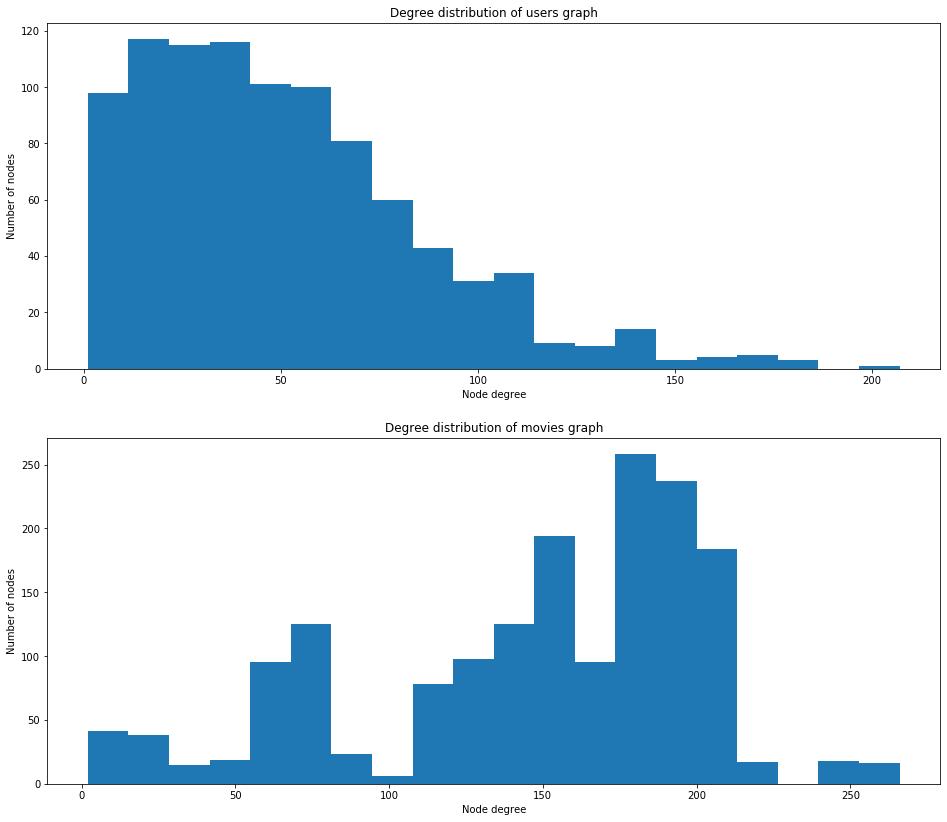

In [318]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 14))
#fig.suptitle('Adjacency matrices of users and movies graph')

ax1.set_title('Degree distribution of users graph')
ax1.set_xlabel('Node degree')
ax1.set_ylabel('Number of nodes')
ax1.hist(x.user_adj.sum(axis = 1), bins = 20)

ax2.set_title('Degree distribution of movies graph')
ax2.set_xlabel('Node degree')
ax2.set_ylabel('Number of nodes')
ax2.hist(x.movie_adj.sum(axis = 1), bins = 20)

In [296]:
import networkx as nx

user_nx = nx.from_numpy_matrix(x.user_adj)
movie_nx = nx.from_numpy_matrix(x.movie_adj)

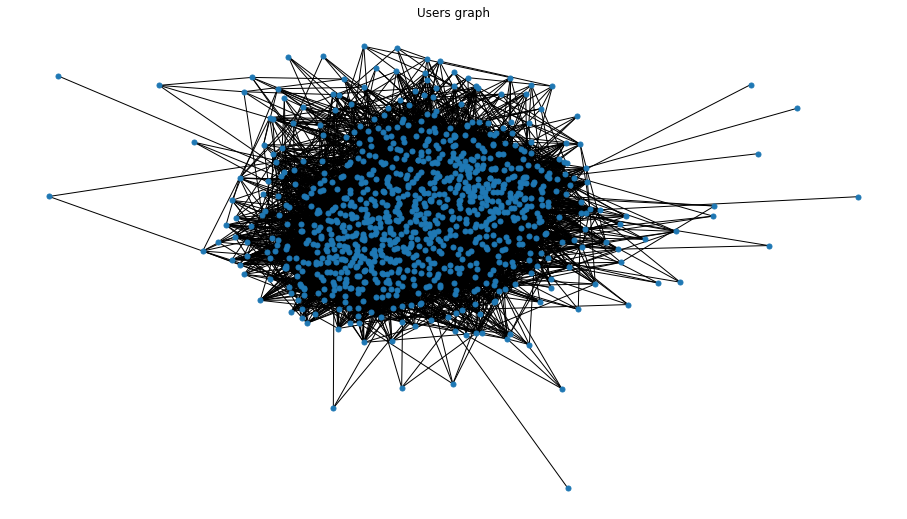

In [297]:
plt.figure(figsize=(16, 9))
plt.title('Users graph')
nx.draw(user_nx, node_size = 25)

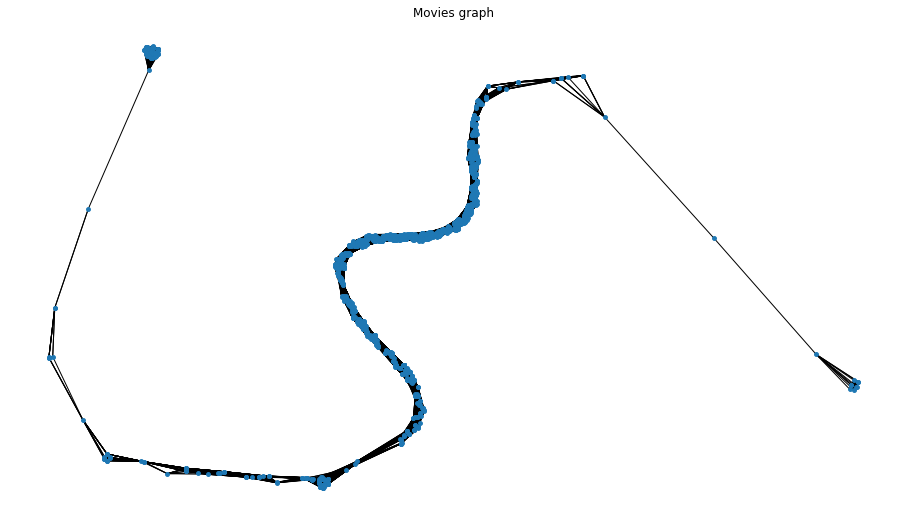

In [298]:
plt.figure(figsize=(16, 9))
plt.title('Movies graph')
nx.draw(movie_nx, node_size = 15)

In [299]:
print('Diameter of users graph:', nx.diameter(user_nx))
print('Diameter of movies graph:', nx.diameter(movie_nx))

Diameter of users graph: 5
Diameter of movies graph: 39


In [300]:
print('Average clustering coefficient of users graph:', nx.average_clustering(user_nx))
print('Average clustering coefficient of movies graph:', nx.average_clustering(movie_nx))

Average clustering coefficient of users graph: 0.2494691253223178
Average clustering coefficient of movies graph: 0.7929261847769834


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   5.,  10.,  62.,  95., 499., 466., 181.,  86.,
        123.,   5., 148.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <a list of 25 Patch objects>)

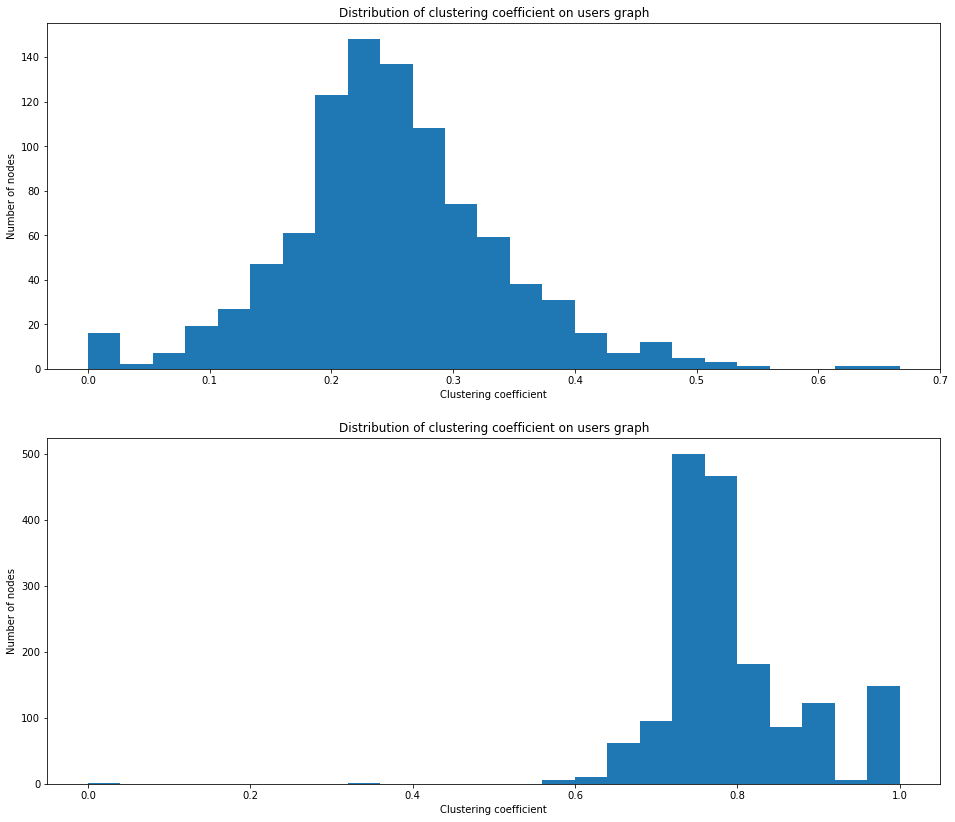

In [341]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 14))

ax1.set_title('Distribution of clustering coefficient on users graph')
ax1.set_xlabel('Clustering coefficient')
ax1.set_ylabel('Number of nodes')
ax1.hist(np.array(list(nx.clustering(user_nx).values())), bins = 25)

ax2.set_title('Distribution of clustering coefficient on users graph')
ax2.set_xlabel('Clustering coefficient')
ax2.set_ylabel('Number of nodes')
ax2.hist(np.array(list(nx.clustering(movie_nx).values())), bins = 25)

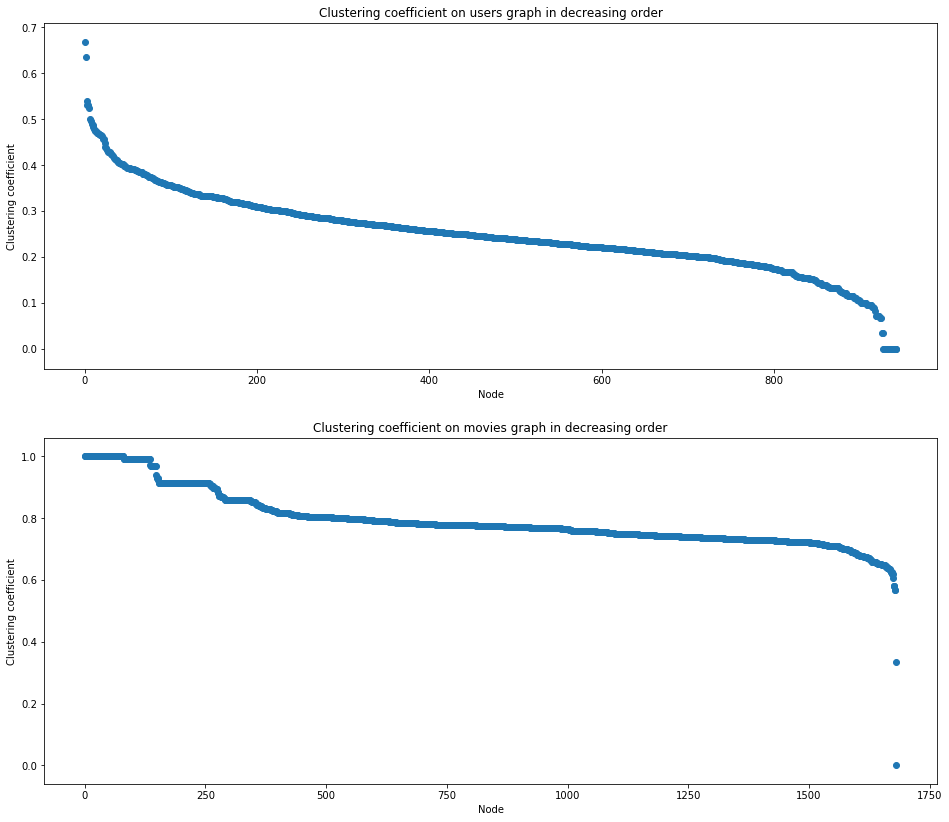

In [342]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 14))

ax1.set_title('Clustering coefficient on users graph in decreasing order')
ax1.set_xlabel('Node')
ax1.set_ylabel('Clustering coefficient')
ax1.scatter(range(x.num_users), np.sort(np.array(list(nx.clustering(user_nx).values())))[::-1])

ax2.set_title('Clustering coefficient on movies graph in decreasing order')
ax2.set_xlabel('Node')
ax2.set_ylabel('Clustering coefficient')
ax2.scatter(range(x.num_movies), np.sort(np.array(list(nx.clustering(movie_nx).values())))[::-1])

In [26]:
# Standard MF with bias
x.cross_validate(learning_rate = .01, regularization_rate = .051, bias = True, seed = 17)

Fold: 1/5

Fold: 2/5

Fold: 3/5

Fold: 4/5

Fold: 5/5

Error: 0.90614


In [365]:
# MF + User filtering
x.cross_validate(learning_rate = .01, regularization_rate = .051, bias = True, seed = 17)

Fold: 1/5

Fold: 2/5

Fold: 3/5

Fold: 4/5

Fold: 5/5

Error: 0.88583


In [370]:
# MF + Movie filtering
x.cross_validate(learning_rate = .01, regularization_rate = .051, bias = True, seed = 17)

Fold: 1/5

Fold: 2/5

Fold: 3/5

Fold: 4/5

Fold: 5/5

Error: 0.90283


In [32]:
# MF + Movie & User filtering
x.cross_validate(learning_rate = .01, regularization_rate = .051, bias = True, seed = 17)

Fold: 1/5

Fold: 2/5

Fold: 3/5

Fold: 4/5

Fold: 5/5

Error: 0.88690


In [349]:
# (MF + Movie) User filtering
x.cross_validate(learning_rate = .017, regularization_rate = .07, bias = True, seed = 17)

Fold: 1/5

Fold: 2/5

Fold: 3/5

Fold: 4/5

Fold: 5/5

Error: 0.88288


In [352]:
# (MF + User) Movie filtering
x.cross_validate(learning_rate = .017, regularization_rate = .04, bias = True, seed = 17)

Fold: 1/5
Final movie_user:   6	0.87405


Fold: 2/5
Final movie_user:   5	0.87932


Fold: 3/5
Final movie_user:   7	0.87659


Fold: 4/5
Final movie_user:   5	0.88308


Fold: 5/5
Final movie_user:   5	0.87338


Error: 0.87729
